# 1.預備

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 2.數據匯入,初步觀察及資料預處理

In [2]:
data = pd.read_excel('Online_Retail.xlsx')

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
data['CustomerID'] = data['CustomerID'].astype('object')
data['Quantity'] = data['Quantity'].astype('float64')

In [5]:
data.isnull().sum(axis = 0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
data = data.loc[(data['CustomerID'].notnull())] #缺失值處理

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  float64       
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 27.9+ MB


In [8]:
data['TotalPrice'] = data['Quantity']*data['UnitPrice'] #產生新column sales表示消費額

In [9]:
#將InvoiceDate細分
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Day'] = np.array([x.day for x in data['InvoiceDate']])
data['Month'] = data.InvoiceDate.values.astype('datetime64[M]')
data['Hour'] = np.array([x.hour for x in data['InvoiceDate']])
data['weekday'] = data['InvoiceDate'].apply(lambda x: pd.to_datetime(x).weekday())
def get_season(dt):
    dt = dt.date()
    if dt.month in [3,4,5]:
        return 'Spring'  
    elif dt.month in [6,7,8]:
        return 'Summer'    
    elif dt.month in [9,10,11]:
        return 'Fall'   
    else:
        return 'Winter'
data['season']=data['InvoiceDate'].apply(get_season)
data_order = data.groupby(['Month','season','Day','Hour','weekday','InvoiceDate','CustomerID']).sum().reset_index()

# 3.資料分析

## 3-1用戶消費特徵分析

Text(0.5, 1.0, 'Monthly consumption')

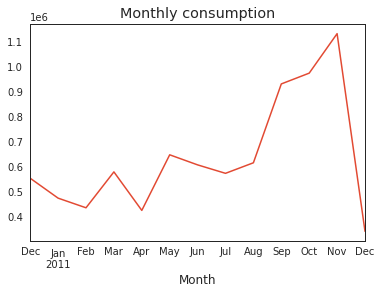

In [11]:
data_order.groupby('Month').TotalPrice.sum().plot()
plt.title('Monthly consumption')

### 11月消費金額異常高，原因可能為促銷

Text(0.5, 1.0, 'Number of Consumption in each month')

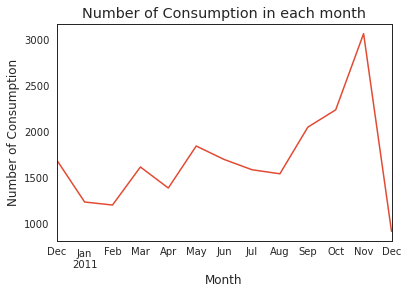

In [15]:
data_order.groupby(['Month']).CustomerID.count().plot()
plt.xlabel('Month')
plt.ylabel('Number of Consumption')
plt.title('Number of Consumption in each month')
plt.xlabel('Month')
plt.ylabel('Number of Consumption')
plt.title('Number of Consumption in each month')

Text(0.5, 1.0, 'Consumers in each month')

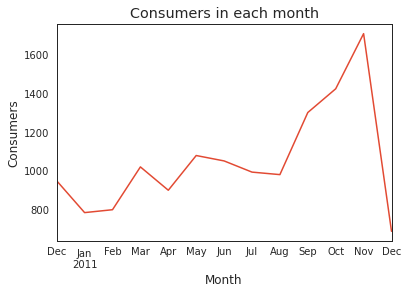

In [16]:
data_order.groupby(['Month']).CustomerID.apply(lambda x: len(x.drop_duplicates())).plot()
plt.xlabel('Month')
plt.ylabel('Consumers')
plt.title('Consumers in each month')

Text(0.5, 1.0, 'Number of products')

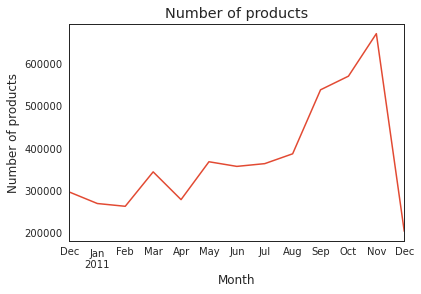

In [18]:
data_order.groupby(['Month']).Quantity.sum().plot()
plt.xlabel('Month')
plt.ylabel('Number of products')
plt.title('Number of products')

### 由上三圖可以觀察到8月後消費額陡升至11月陡降，觀察資料發現原因為12月中後無資料

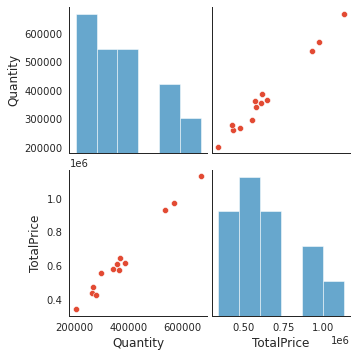

In [19]:
df=data_order.groupby(['Month']).sum()
sns.pairplot(df,vars=["Quantity", "TotalPrice"],palette="husl")
plt.show()

### 每月消費金額與每月賣出產品數呈正比線性關係，之後可採用薄利多銷的方式以增加每月消費額

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Users Count'),
 Text(0.5, 1.0, 'TotalPrice By Hour Of The Day Across Weekdays'),
 None]

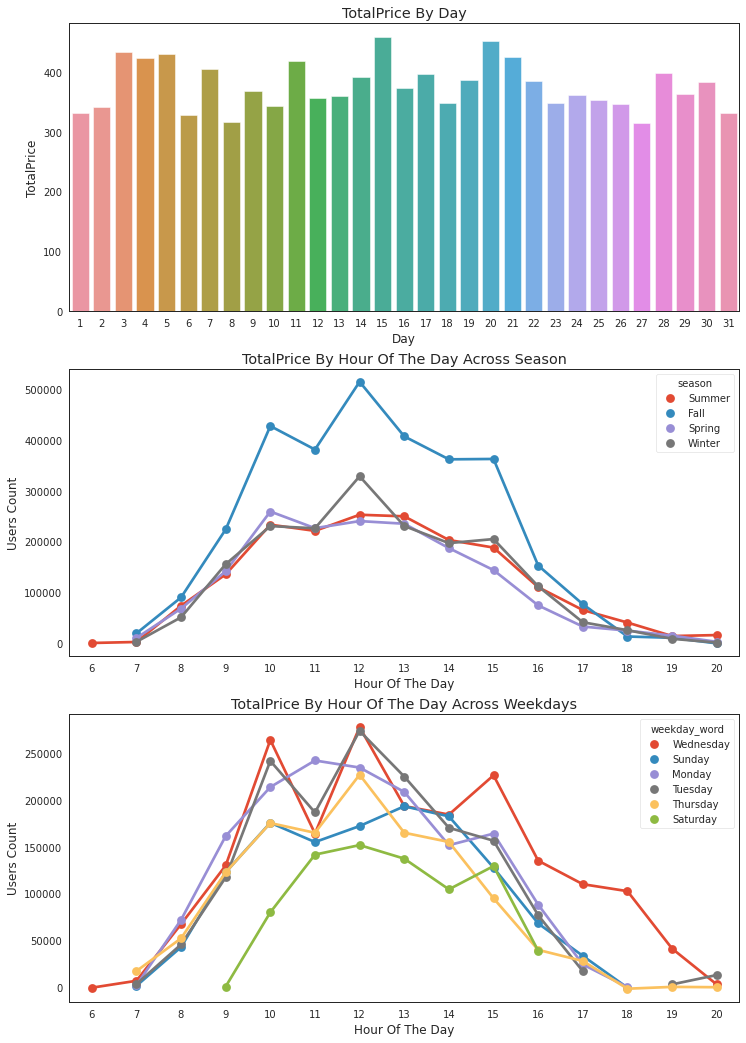

In [20]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3)
fig.set_size_inches(12,18)
seasonDict={1:'Spring',2:'Summer',3:'Fall',4:'Winter'}
weekDict = {0:"Sunday",1:"Monday",2:"Tuesday",3:"Wednesday",4:"Thursday",5:"Friday",6:"Saturday"}

dayPrice = pd.DataFrame(data_order.groupby("Day")["TotalPrice"].sum()/data_order.groupby("Day")["TotalPrice"].count()).reset_index()
sns.barplot(data=dayPrice,x="Day",y="TotalPrice",ax=ax1)
ax1.set(xlabel='Day', ylabel='TotalPrice',title="TotalPrice By Day")

hourseasonPrice = pd.DataFrame(data_order.groupby(["Hour","season"],sort=True)["TotalPrice"].sum()).reset_index()
sns.pointplot(x=hourseasonPrice["Hour"], y=hourseasonPrice["TotalPrice"],hue=hourseasonPrice["season"], data=hourseasonPrice, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="TotalPrice By Hour Of The Day Across Season",label='big')

hourweekPrice = pd.DataFrame(data_order.groupby(["Hour","weekday"],sort=True)["TotalPrice"].sum()).reset_index()
hourweekPrice["weekday_word"]=hourweekPrice["weekday"].map(weekDict)
sns.pointplot(x=hourweekPrice["Hour"], y=hourweekPrice["TotalPrice"],hue=hourweekPrice["weekday_word"], data=hourweekPrice, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="TotalPrice By Hour Of The Day Across Weekdays",label='big')

### 由第一張圖發現理應最多消費額的月初並不如預期，可以針對這一點在月初採取一些促銷手段。
### 由第二及第三張圖發現季節方面秋季消費最高；星期方面周二周三消費較高，最低的為周六。

## 3-2用戶個體消費分析

In [24]:
data_id = data.groupby('CustomerID').sum()
data_id.describe()

,Quantity,UnitPrice,TotalPrice,Day,Hour,weekday
count,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000
mean,1122.344007,322.008226,1898.459701,1399.161253,1185.263724,242.534309
std,4672.790720,1284.783098,8219.345141,3634.542726,3036.034307,582.155928
min,-303.000000,0.000000,-4287.630000,1.000000,8.000000,0.000000
25%,153.000000,52.865000,293.362500,200.750000,207.000000,30.000000
50%,365.000000,130.095000,648.075000,620.000000,520.500000,93.000000
75%,962.250000,302.332500,1611.725000,1523.250000,1277.250000,258.000000
max,196719.000000,41376.330000,279489.020000,122070.000000,105546.000000,19200.000000


### 發現Quantity及TotalPrice方差皆很大，說明少部分人進行了大量的消費

Text(0.5, 1.0, 'Amount of consumption Picture')

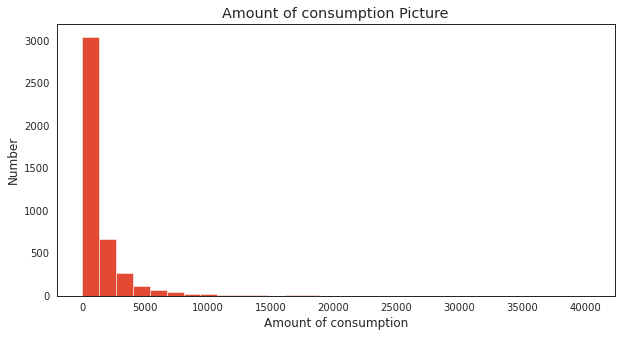

In [28]:
plt.figure(figsize=(10,5))
plt.hist(data_id.query('0 < TotalPrice < 42993').TotalPrice, bins = 30)
plt.xlabel('Amount of consumption')
plt.ylabel('Number')
plt.title('Amount of consumption Picture')

### 消費金額為0~1000為大宗用戶，5000以內為值得挖掘客戶

In [33]:
data_id['num'] = 1
data_id_1 = data_id.sort_values('TotalPrice')
data_id_2 = data_id_1.apply(lambda x:x.cumsum()/x.sum())

Text(0, 0.5, 'Percentage of consumption')

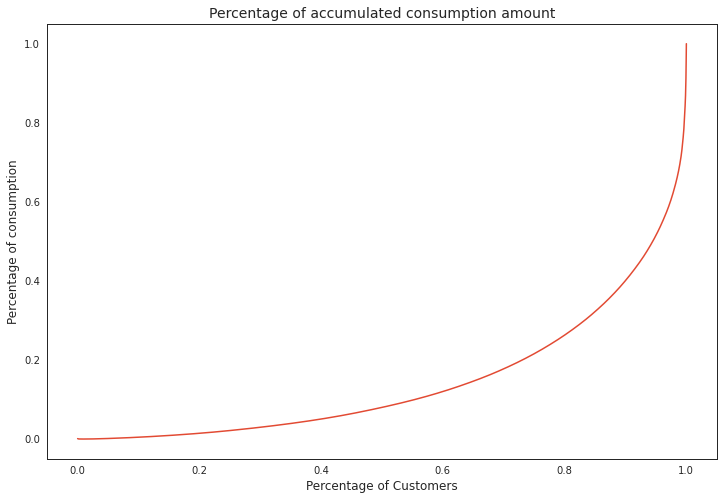

In [35]:
plt.figure(figsize=(12,8))
sns.lineplot(x='num',y='TotalPrice',data = data_id_2)
plt.title('Percentage of accumulated consumption amount',fontsize=14)
plt.xlabel('Percentage of Customers',fontsize=12)
plt.ylabel('Percentage of consumption',fontsize=12)

### 再次驗證少數人進行了多數消費

## 3-3複購率及回購率分析

In [36]:
pivoted_counts = data_order.pivot_table(index = 'CustomerID', columns = 'Month',
                               values = 'InvoiceDate', aggfunc = 'count').fillna(0)

columns_month = data_order.Month.sort_values().astype('str').unique()
pivoted_counts.columns = columns_month
pivoted_counts.head()

,2010-12-01,2011-01-01,2011-02-01,2011-03-01,2011-04-01,2011-05-01,2011-06-01,2011-07-01,2011-08-01,2011-09-01,2011-10-01,2011-11-01,2011-12-01
CustomerID,,,,,,,,,,,,,
12346.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12347.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
12348.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12350.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
pivoted_r = pivoted_counts.applymap(lambda x: 1 if x > 1 else np.NaN if x == 0 else 0)
pivoted_r.head()

,2010-12-01,2011-01-01,2011-02-01,2011-03-01,2011-04-01,2011-05-01,2011-06-01,2011-07-01,2011-08-01,2011-09-01,2011-10-01,2011-11-01,2011-12-01
CustomerID,,,,,,,,,,,,,
12346.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12347.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
12348.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
12349.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
12350.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

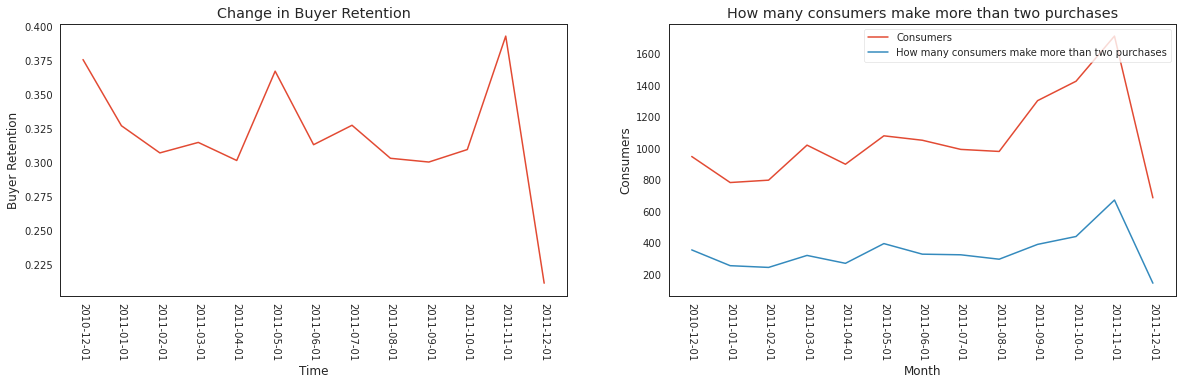

In [41]:
df_duplicate = pd.DataFrame(pivoted_r.sum()/ pivoted_r.count()).reset_index()
df_duplicate.columns=('Month','MonthRate')
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.plot(df_duplicate.Month, df_duplicate.MonthRate)
plt.xlabel('Time')
plt.ylabel('Buyer Retention')

plt.xticks(rotation=-90)
plt.title('Change in Buyer Retention')
plt.subplot(122)
plt.plot(pivoted_r.count())
plt.plot(pivoted_r.sum())
plt.xlabel('Month') 
plt.ylabel('Consumers') 
plt.title('How many consumers make more than two purchases')
legends = ['Consumers', 'How many consumers make more than two purchases']
plt.legend(legends,loc = 'upper right')
plt.xticks(rotation=-90)

### 月複購率幾乎皆達到30%，最高的2010的12月及2011的5,11月，皆達到35%，原因可能為年中及年末促銷活動。
### 新老客戶數呈正比。

In [39]:
df_purchase = pivoted_counts.applymap(lambda x: 1 if x > 0 else 0)
df_purchase.head()

,2010-12-01,2011-01-01,2011-02-01,2011-03-01,2011-04-01,2011-05-01,2011-06-01,2011-07-01,2011-08-01,2011-09-01,2011-10-01,2011-11-01,2011-12-01
CustomerID,,,,,,,,,,,,,
12346.0,0,1,0,0,0,0,0,0,0,0,0,0,0
12347.0,1,1,0,0,1,0,1,0,1,0,1,0,1
12348.0,1,1,0,0,1,0,0,0,0,1,0,0,0
12349.0,0,0,0,0,0,0,0,0,0,0,0,1,0
12350.0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [40]:
def purchase_back(data):
    status = []
    for i in range(12):
        if data[i] == 1:
            if data[i+1] == 1:
                status.append(1)         
            if data[i+1] == 0:
                status.append(0)           
        else:
            status.append(np.NaN)         
    status.append(np.NaN)
    return pd.Series(status, index=columns_month)
purchase_b = df_purchase.apply(purchase_back, axis=1)
purchase_b.head()

,2010-12-01,2011-01-01,2011-02-01,2011-03-01,2011-04-01,2011-05-01,2011-06-01,2011-07-01,2011-08-01,2011-09-01,2011-10-01,2011-11-01,2011-12-01
CustomerID,,,,,,,,,,,,,
12346.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12347.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN
12348.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
12349.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
12350.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

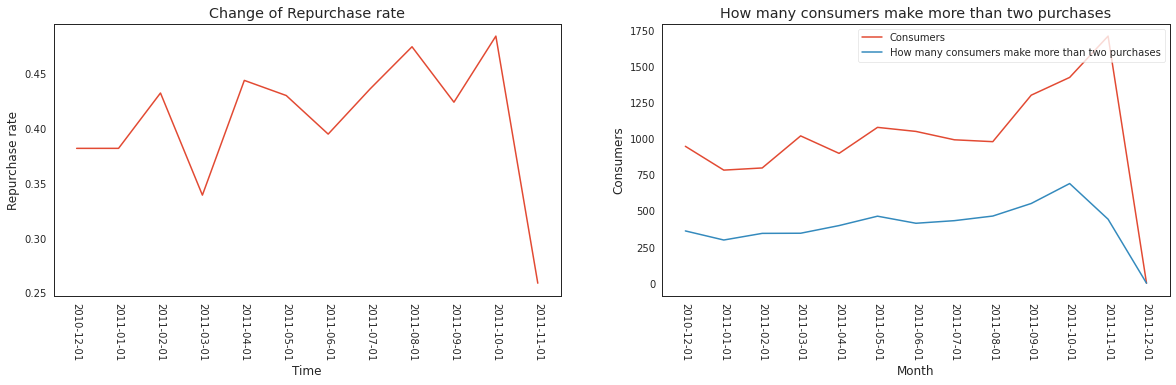

In [42]:
df_Purchase = pd.DataFrame(purchase_b.sum()/purchase_b.count()).reset_index()
df_Purchase.columns = ('Month','PurchaseRate')
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.plot(df_Purchase.Month, df_Purchase.PurchaseRate)
plt.xlabel('Time')
plt.ylabel('Repurchase rate')
plt.title('Change of Repurchase rate')
plt.xticks(rotation=-90)

plt.subplot(122)
plt.plot(purchase_b.count())
plt.plot(purchase_b.sum())
plt.xlabel('Month') 
plt.ylabel('Consumers') 
plt.title('How many consumers make more than two purchases')
legends = ['Consumers', 'How many consumers make more than two purchases']
plt.legend(legends,loc = 'upper right')
plt.xticks(rotation=-90)

### 回購率大約落於40%，較複購率高，且觀察右圖可發現回購人數穩定，因此判斷波動為月份營業額不同之影響。
### 整體而言，老客戶的忠誠度佳。

# 4.顧客分類

##  4-1活躍度

In [43]:
def active_status(data):
    status = []
    for i in range(13):

        if data[i] == 0:
            if len(status) > 0:
                if status[i-1] == 'unreg':
                    status.append('unreg')
                else:
                    status.append('unactive')
            else:
                status.append('unreg')

        else:
            if len(status) == 0:
                status.append('new')
            else:
                if status[i-1] == 'unactive':
                    status.append('return')
                elif status[i-1] == 'unreg':
                    status.append('new')
                else:
                    status.append('active')
    return pd.Series(status, index=columns_month)
purchase_stats = df_purchase.apply(active_status, axis = 1)
purchase_stats.head()

,2010-12-01,2011-01-01,2011-02-01,2011-03-01,2011-04-01,2011-05-01,2011-06-01,2011-07-01,2011-08-01,2011-09-01,2011-10-01,2011-11-01,2011-12-01
CustomerID,,,,,,,,,,,,,
12346.0,unreg,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
12347.0,new,active,unactive,unactive,return,unactive,return,unactive,return,unactive,return,unactive,return
12348.0,new,active,unactive,unactive,return,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive
12349.0,unreg,unreg,unreg,unreg,unreg,unreg,unreg,unreg,unreg,unreg,unreg,new,unactive
12350.0,unreg,unreg,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive


In [44]:
purchase_status_counts = purchase_stats.replace('unreg', np.NaN).apply(lambda x:pd.value_counts(x))
purchase_status_counts

,2010-12-01,2011-01-01,2011-02-01,2011-03-01,2011-04-01,2011-05-01,2011-06-01,2011-07-01,2011-08-01,2011-09-01,2011-10-01,2011-11-01,2011-12-01
active,NaN,362.0,299,345,346,399,464,415,433,465,552,690,443
new,948.0,421.0,380,440,299,279,235,191,167,298,352,321,41
return,NaN,NaN,119,235,254,401,352,387,380,539,521,700,202
unactive,NaN,586.0,951,1169,1589,1688,1951,2200,2380,2356,2585,2620,3686


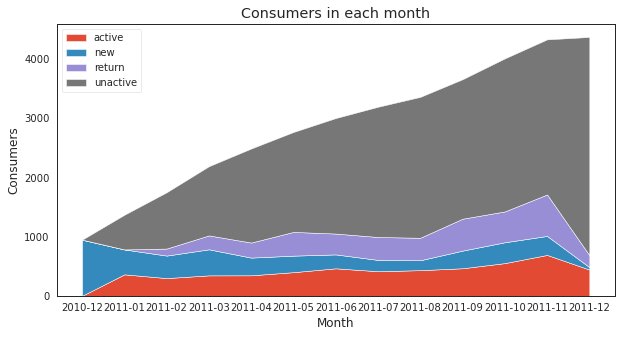

In [46]:
u = purchase_status_counts.fillna(0).T.reset_index()
labels = u[['active','new','return','unactive']].columns

plt.figure(figsize=(10,5))
plt.stackplot(u['index'].astype(str).apply(lambda x:x[:-3]), u['active'],u['new'],u['return'],u['unactive'], labels=labels)
plt.xlabel('Month')
plt.ylabel('Consumers')
plt.title('Consumers in each month')
plt.legend(loc = 'upper left');

### 除了不活躍用戶外，其餘皆穩定(11月增多為促銷緣故)。
### 不活躍用戶持續增長，應制定策略挽回。

## 4-2 RFM

In [47]:
rfm = data.pivot_table(index = 'CustomerID',
                  values = ['Quantity','TotalPrice','InvoiceDate'],
              aggfunc = {'Quantity':'sum',
                        'TotalPrice':'sum',
                        'InvoiceDate':'max'})

rfm['InvoiceDate'] = -(rfm.InvoiceDate - rfm.InvoiceDate.max()) / np.timedelta64(1, 'D')
rfm.rename(columns={'InvoiceDate':'R', 'Quantity':'F', 'TotalPrice':'M'}, inplace = True)
krfm=rfm
rfm.head()

,R,F,M
CustomerID,,,
12346.0,325.106250,0.0,0.00
12347.0,1.873611,2458.0,4310.00
12348.0,74.984028,2341.0,1797.24
12349.0,18.124306,631.0,1757.55
12350.0,309.867361,197.0,334.40


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


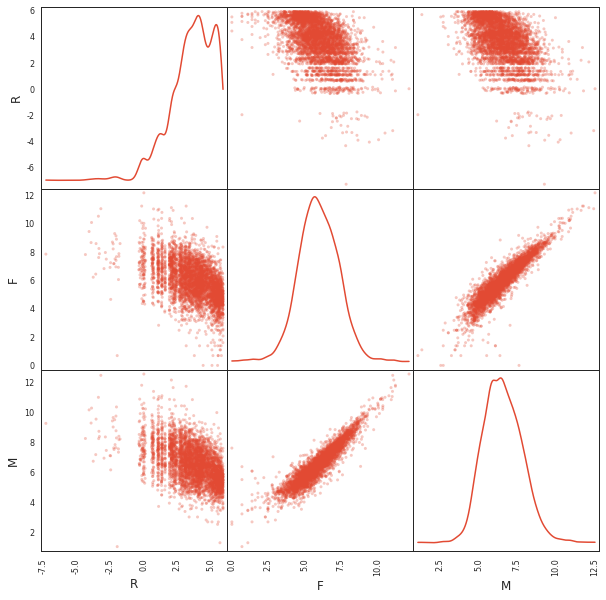

In [48]:
rfm = rfm[rfm != 0].dropna()
log_rfm = np.log(rfm)
pd.plotting.scatter_matrix(log_rfm, alpha = 0.3, figsize = (10,10), diagonal = 'kde');

### F,M值呈常態分佈，R值則呈偏右常態分佈；F,M呈正比且與R有弱相關性。

In [49]:
def rfm_func(x):
    level = x.apply(lambda x:'1' if x > 0 else '0')
    label = level.R + level.F + level.M
    d = {
        '111':'most value customer', 
        '011':'most keeping customer', 
        '101':'most stay customer',
        '001':'most development customer',
        '110':'normal value customer',
        '010':'normal keeping customer',
        '100':'normal stay customer',
        '000':'normal development customer'
    }
    result = d[label]
    return result

log_rfm['label'] = log_rfm[['R','F','M']].apply(lambda x:x-x.median()).apply(rfm_func, axis=1)
log_rfm.groupby('label').sum()

,R,F,M
label,,,
most development customer,266.584848,570.519200,684.519925
most keeping customer,3020.537146,9917.396216,10637.002312
most stay customer,496.846952,575.178028,696.192769
most value customer,2690.811634,3986.839441,4289.411958
normal development customer,1764.478507,3119.262918,3500.021333
normal keeping customer,239.913396,530.671753,528.843860
normal stay customer,6946.311079,6302.997189,7272.700231
normal value customer,581.260174,754.855781,734.493794


In [51]:
from mpl_toolkits.mplot3d import Axes3D

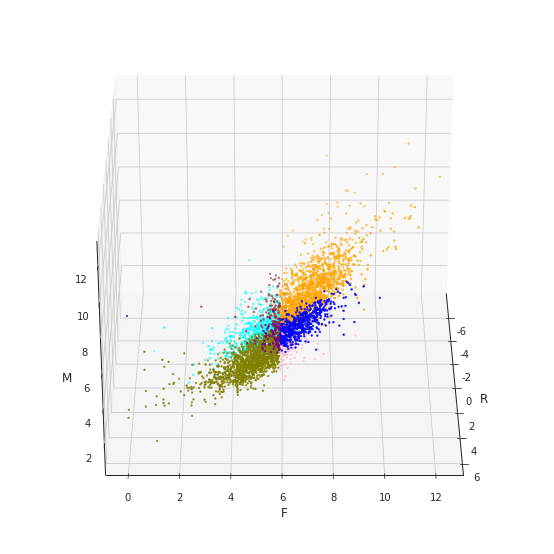

In [63]:
d = {
    'most value customer': 'blue',
    'most keeping customer': 'orange', 
    'most stay customer': 'purple',
    'most development customer': 'brown',
    'normal value customer': 'pink',
    'normal keeping customer': 'gray',
    'normal stay customer': 'olive',
    'normal development customer': 'cyan'
}

log_rfm['color'] = log_rfm['label'].map(d)

fig = plt.figure(figsize=(10,7.5)) 
ax = Axes3D(fig) 
ax.scatter(log_rfm.R,log_rfm.F,log_rfm.M, c=log_rfm.color, s=3)

ax.set_xlabel('R') 
ax.set_ylabel('F')
ax.set_zlabel('M')

ax.view_init(elev=30,azim=0)

### 針對R0,R1顧客，找出共性反推不活躍及流失原因。
### 針對F0,F1顧客，調查登錄與否理由，找尋產品改良方式。
### 針對M1顧客，給予新產品體驗，及時得到最新回饋；針對M0顧客，進行顧客研究找尋共性。

## 4-3 Kmeans

In [64]:
def zscore_data(data):
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    data.columns = ['Z' + i for i in data.columns]
    return data
kmrfm=krfm[['R','F','M']]
data = zscore_data(kmrfm)
iteration=500
kmodel = KMeans(n_clusters = 4, n_jobs = -1,max_iter = iteration)
kmodel.fit(data) #训练模型
r1 = pd.Series(kmodel.labels_).value_counts()
r2 = pd.DataFrame(kmodel.cluster_centers_)
r = pd.concat([r2, r1], axis=1)
r.columns = list(data.columns) + ['Number of Category']

r = pd.concat([data, pd.Series(kmodel.labels_, index=data.index)], axis=1)
r.columns = list(data.columns) + ['Category']
print(kmodel.cluster_centers_)
print(kmodel.labels_)
r.head()

[[-5.09645551e-01 -2.22446429e-02 -2.21858752e-02]
 [-8.41494097e-01  2.04879828e+01  2.36080961e+01]
 [ 1.54825562e+00 -1.83834374e-01 -1.73524101e-01]
 [-8.49159592e-01  6.29301718e+00  5.29267437e+00]]
[2 0 0 ... 0 0 0]


,ZR,ZF,ZM,Category
CustomerID,,,,
12346.0,2.317517,-0.240187,-0.230975,2
12347.0,-0.890082,0.285837,0.293398,0
12348.0,-0.164571,0.260798,-0.012315,0
12349.0,-0.728818,-0.105150,-0.017144,0
12350.0,2.166294,-0.198028,-0.190290,2


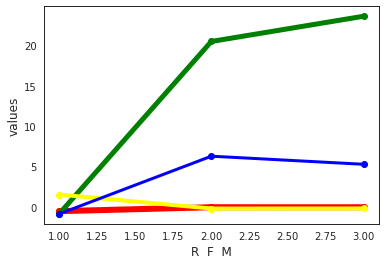

In [65]:
clu = kmodel.cluster_centers_  
x = [1,2,3]  
colors = ['red','green','yellow','blue']  
for i in range(4):  
   plt.plot(x,clu[i],label='clustre '+str(i),linewidth=6-i,color=colors[i],marker='o')   
plt.xlabel('R  F  M')  
plt.ylabel('values')  
plt.show()  

### 客群重要程度:綠>藍>紅>黃，進行分析找尋共性。

# 5.提高顧客質量

## 5-1生命週期分析

191.18712030375715

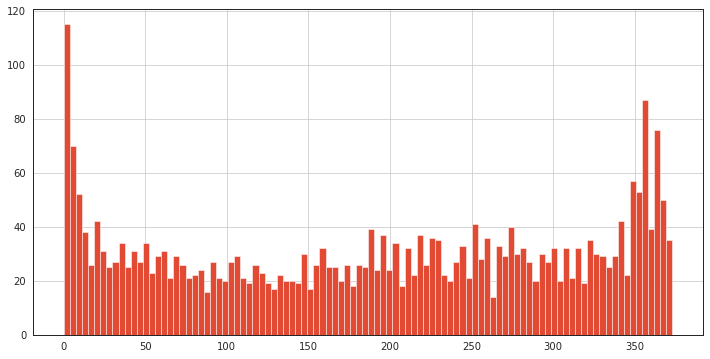

In [66]:
user_purchase = data_order[['CustomerID', 'Quantity', 'InvoiceDate','TotalPrice']]
order_date_min = user_purchase.groupby('CustomerID').InvoiceDate.min()
order_date_max = user_purchase.groupby('CustomerID').InvoiceDate.max()
(order_date_max - order_date_min).head(10)

life_time =(order_date_max - order_date_min).reset_index()
life_time.columns=('CustomerID','day')
plt.figure(figsize=(10,5))
life_time['life_time'] = life_time.day/ np.timedelta64(1,'D')
life_time[life_time.life_time > 0].life_time.hist(bins = 100, figsize = (12,6))
life_time[life_time.life_time > 0].life_time.mean()

### 呈雙峰趨勢圖，應針對首次消費的一個月內進行再次消費引導。

In [70]:
(order_date_max - order_date_min).mean()

Timedelta('133 days 17:25:29.204025620')

In [71]:
life_time[life_time.life_time > 0].life_time.mean()

191.18712030375715

### 消費兩次以上的顧客生命週期為191天，為總體133天的1.5倍，因此應針對首次消費的顧客進行再次消費引導。

## 5-2留存率

In [72]:
user_purchase_rentention = pd.merge(left=user_purchase,right=order_date_min.reset_index(),how='inner',on='CustomerID'
                                    ,suffixes=('','_min'))
user_purchase_rentention.head(5)
user_purchase_rentention['InvoiceDate_diff']=((user_purchase_rentention.InvoiceDate-user_purchase_rentention.InvoiceDate_min)/ np.timedelta64(1,'D')).astype(int)
bins=[0,3,7,15,30,60,90,180,374]
user_purchase_rentention['InvoiceDate_diff_bin']=pd.cut(user_purchase_rentention.InvoiceDate_diff,bins=bins)
pivoted_retention=user_purchase_rentention.pivot_table(index='CustomerID',columns='InvoiceDate_diff_bin',values='TotalPrice',aggfunc=sum)

<AxesSubplot:xlabel='InvoiceDate_diff_bin'>

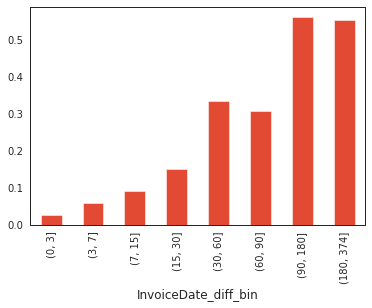

In [73]:
pivoted_retention_trans=pivoted_retention.fillna(0).applymap(lambda x:1 if x>0 else 0)
(pivoted_retention_trans.sum()/pivoted_retention_trans.count()).plot.bar()

### 留存率逐步遞增，使已消費顧客持續消費是營運重點，可於生命週期一半時進行推廣。

## 5-3用戶平均消費週期分析

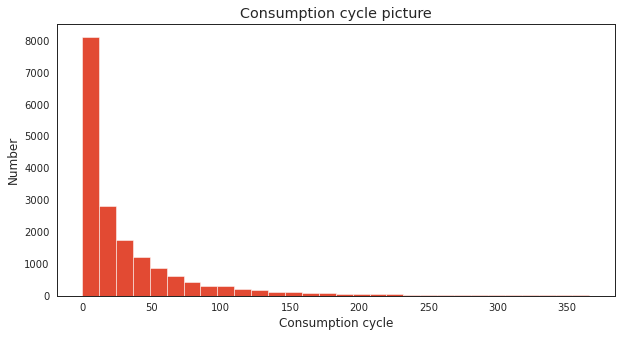

In [74]:
grouped_cus_order = data_order.groupby('CustomerID')
order_diff = grouped_cus_order.apply(lambda x:x.InvoiceDate - x.InvoiceDate.shift())
order_diff.head(10)
order_diff.describe()
plt.figure(figsize=(10,5))
plt.hist((order_diff / np.timedelta64(1, 'D')).dropna(), bins = 30)
plt.xlabel('Consumption cycle')
plt.ylabel('Number')
plt.title('Consumption cycle picture');

### 呈長尾分布，可採用消費後贈送期限內優惠卷方式，縮短顧客消費週期。